# INFO 2950 Final Project 

## Fund Investment Decisions: Mutual Funds or Exchange Traded Funds?

By Cameron Robinson (ctr48) , David Vilensky (dlv46) , Cassandra Kaufman (cpk57) , and Emily Sobel (es983)

## Introduction

---- insert introduction ----

 __Research Question:__

What set of criteria is most important to the sucess of a mutual fund? What about amongst ETFs? Which type of fund is more successful overall can can the success of a fund be accurately predicted based on these observed criteria?

## Importing

In [4]:
# imports and settings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import chi2_contingency
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import re

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.style.use('seaborn-poster')

## Data Overview



The file contains 24,821 Mutual Funds and 1,680 ETFs with general aspects (as Total Net Assets, management company and size), portfolio indicators (as cash, stocks, bonds, and sectors), returns (as yeartodate, 2020-11) and financial ratios (as price/earning, Treynor and Sharpe ratios, alpha, and beta). This data was scraped from Yahoo Finance by kaggle user Stefano Leone.

Link to dataset: https://www.kaggle.com/stefanoleone992/mutual-funds-and-etfs


__Exchange Traded Funds Dataset: 'ETFs.csv'__


In [5]:
df_etf=pd.read_csv('USData/ETFs.csv')

__Mutual Funds Dataset: 'Mutual Funds.csv'__

In [6]:
df_mf=pd.read_csv('USData/Mutual Funds.csv')

C:\Users\camro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (167,171) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Data Description

The two datasets used were created to allow for multiple comparisons regarding portfolio decisions from investment managers in Mutual Funds and portfolio restrictions to the indexes in Exchnage traded funds. Each of the datasets are composed of publicly available information and were not funded by any companies or private organizations. The instances in each of the datasets are  funds with the respective fund type, either Exchange traded funds in the ETF.csv or Mutual funds in the Mutual Funds.csv. The columns in each of the datasets contain information on the respective fund's financial ratios, sector investments, risk ratios, and returns. The data in each of the datasets was collected over a time period between 2011 and 2020. The original datasets don't have any errors but they do contain null information in the form of empty columns that were dropped during our data cleaning. This preprocessing and all other preprocessing of the data found in the two datasets is extensively documented in our data cleaning section and we have made no additional modifications or alterations to the data. The creator of the datasets placed no copyrights or restrictions on their use and under its license of CC0: Public Domain, we have permission to access and use its both of the datsets content for our project. 
 

## Data Cleaning

Since our datasets are rather large, we created a method that allowed us to break down and sort either dataset based off keywords in column names : 

In [7]:
### Creates and returns a subset of df_mf by keeping only the columns with 'keyword' in their column name. 
def cleanbykeyword(df,keyword):
    """
    Searches and creates a list of all of the column names in df that contain the keyword.
    Subsets the df according to this list, then creates a df_new dataframe with this 
    information and drops the corresponding columns from the original df.

    Arguments:
        df: Dataset pandas DataFrame.
        cols: List of columns to be included in calculations. 
        keyword: Word to be removed from column name in order to preserve clarity with labeling.
        
        
    Return: dataframe containing data matching keyword.
    """
    col_list=[ i for i in df.columns if (keyword in i)] 
    #print(col_list)
    df_new=df[col_list]
    df.drop(columns=col_list,axis=1,inplace=True) #removes duplicate data from df_mf masterframe
    df_new.insert(0,'fund_symbol',df.fund_symbol) #inserts the fund symbols as the 1st column of the new data set
    return (df_new)

Throwing away empty columns and columns not used in our analysis: 

In [8]:
empty_cols2 = [col for col in df_etf.columns if df_etf[col].isnull().all()]
df_etf.drop(empty_cols2,
        axis=1,
        inplace=True)

throwaway_cols=[
    'quarters_up',
    'quarters_down',
    'top10_holdings',
    'years_up',
    'years_down',
    'currency'
]
df_mf.drop(columns=throwaway_cols,axis=1,inplace=True)
df_etf.drop(columns=throwaway_cols[2:],axis=1,inplace=True)

df_etf.to_csv('NoEmptiesETFs.csv',index=False)
df_mf.to_csv('NoEmptiesMutual Funds.csv',index=False)



Removing category data from the dataframe. Some of the category columns were not updated properly in the data set and therefore cannot be used in our analyses, we drop them to save space:

In [9]:
df_mf_category_data=cleanbykeyword(df_mf,'category_')
df_etf_category_data=cleanbykeyword(df_etf,'category_')

__Using our clean by keyword method to break the dataframe into more easily accessible parts:__

In [10]:
#standard deviation
df_mf_standard_deviations= cleanbykeyword(df_mf,'standard_deviation')
df_etf_standard_deviations=cleanbykeyword(df_etf,'standard_deviation')

df_etf_standard_deviations.to_csv('stdsETFs.csv',index=False)
df_mf_standard_deviations.to_csv('stdsMutual Funds.csv',index=False)

#sector
df_mf_sector=cleanbykeyword(df_mf,'sector')
df_etf_sector=cleanbykeyword(df_etf,'sector')

df_etf_sector.to_csv('sectorsETFs.csv',index=False)
df_mf_sector.to_csv('sectorsMutual Funds.csv',index=False)

#ratios
df_mf_ratios=cleanbykeyword(df_mf,'_ratio')
df_etf_ratios=cleanbykeyword(df_etf,'_ratio')

df_etf_ratios.to_csv('ratiosETFs.csv',index=False)
df_mf_ratios.to_csv('ratiosMutual Funds.csv',index=False)
                    
#alpha & beta 
df_mf_alpha=cleanbykeyword(df_mf,'alpha')
df_etf_alpha=cleanbykeyword(df_etf,'alpha')

df_mf_beta=cleanbykeyword(df_mf,'beta')
df_etf_beta=cleanbykeyword(df_etf,'beta')
                    
#credit
df_mf_credit=cleanbykeyword(df_mf,'credit').dropna()
df_etf_credit=cleanbykeyword(df_etf,'credit').dropna()
df_mf_credit.to_csv('creditsMutual Funds.csv',index=False)

#R squared
df_mf_rsquare=cleanbykeyword(df_mf,'squared')
df_etf_rsquare=cleanbykeyword(df_etf,'squared')

#assets
df_mf_asset=cleanbykeyword(df_mf,'asset')
df_etf_asset=cleanbykeyword(df_etf,'asset')

df_etf_asset.to_csv('assetsETFs.csv',index=False)
df_mf_asset.to_csv('assetsMutual Funds.csv',index=False)\
                    
#fund return
df_mf_return_history=cleanbykeyword(df_mf,'_return_')
df_etf_return_history=cleanbykeyword(df_etf,'_return_').dropna()

df_etf_return_history.to_csv('returnsETFs.csv',index=False)
df_mf_return_history.to_csv('returnsMutual Funds.csv',index=False)

    #Adds fund_return_ytd column to main datafrme and removes from return history subframe
df_mf['fund_return_ytd']=df_mf_return_history['fund_return_ytd']
df_etf['fund_return_ytd']=df_etf_return_history['fund_return_ytd']
df_mf_return_history=df_mf_return_history.drop(columns=['fund_return_ytd'])
df_etf_return_history=df_etf_return_history.drop(columns=['fund_return_ytd'])
    
#Removing quarterly data from return history
#cleanbykeyword(df_mf_return_history,'_q')
#cleanbykeyword(df_etf_return_history,'_q')

#merging datasets containing R-Squares, Alpha, and Beta values into a single data set:
df_mf_stats=df_mf_rsquare.merge(df_mf_alpha,how='left')
df_mf_stats=df_mf_stats.merge(df_mf_beta,how='left')
df_mf_stats.to_csv('statsMutual Funds.csv',index=False)
df_mf_stats.head()

df_etf_stats=df_etf_rsquare.merge(df_etf_alpha,how='left')
df_etf_stats=df_etf_stats.merge(df_etf_beta,how='left')
df_etf_stats.to_csv('statsETFs.csv',index=False)


# Methods Used Section

Methods used for data exploration:

In [166]:
#creates a pie chart representing the relative distribution of funds in a certain category 
def pie_chart(df,column):
    '''
    Param df: Pandas dataframe
    Param column: column in df that is to be analyzed.
    '''
    grouped=df.groupby(column).fund_symbol.count().to_frame()
    plt.pie(grouped.fund_symbol,labels=grouped.index,autopct='%.2f%%')
    plt.show()


In [167]:
#creats a pie chart representing the % composition of a certain range of values in a dataset.
def percent_comp_bar(df,cols,keyword):
    """
    Creates a pie chart for a given DataFrame subset. Each section in the pie chart
    represents a column mean within the dataframe, which corresponds to a % invested
    in a given category (sector/asset)
    
    Arguments:
        df: Dataset pandas DataFrame.
        cols: List of columns to be included in calculations. 
        keyword: Word to be removed from column name in order to preserve clarity with labeling.
    """
    col_names=[]
    other=0
    col_sums=[]
    for column in cols:
        col_sum=df[column].mean()
        if(col_sum<1 or 'other' in column):
            other+=col_sum
        else:
            col_names.append(column.replace(keyword,''))
            col_sums.append(df[column].mean())
    if(other>0.1):
        col_names.append('other')
        col_sums.append(other)
    plt.pie(col_sums,labels=col_names,autopct='%.2f%%') 
    plt.show()


In [168]:
#Draws a boxplot representing the dependent column as a function of the independent column
def dep_by_indep_boxplot(df_joined,independent,dependent,fundtype):
    '''
    Param df_joined: dataframe containing both the independent and dependent columns
    Param independent: column which serves as the independent variable
    Param dependent: column which serves as the dependent variable which is analyzed and plotted according to the dependent column.
    Param fundtype: Name of fund that is printed at the start of execution.
    '''
    
    print('\n Distribution of {} according to {} in {}'.format(dependent,independent,fundtype)+':\n')

    colors=['blue','grey','magenta','yellow','cyan','orange']    
    criteria=[i for i in df_joined[independent].sort_values(ascending=True).dropna().unique()]
    col_count=len(criteria)
    table=df_joined.melt(id_vars=[independent],value_vars=[dependent]).dropna()
    
    fig,ax=plt.subplots(nrows=1,ncols=col_count,figsize=(15,9))
    for i in range(0,col_count):
        sns.boxplot(data=table.where(table[independent]==criteria[i]).value,ax=ax[i],color=colors[i])
        ax[i].set_title(independent + ' = ' + str(criteria[i]))
        plt.tight_layout()
    plt.show()
    

In [169]:
#Creates a bar plot of the 20 most common values in the given column
def distribution_by_category(df):
    '''
    Param df: dataframe of funds containing category type.
    
    '''
    cat_count=df['category'].value_counts()[:20]
    sns.barplot(x=cat_count.values,y=cat_count.index)
    plt.title('Distribution by Category')
    plt.tight_layout
    plt.show()

Methods used for analysis: 

In [170]:
## returns a data frame of the correlations of the variables in the 'predictors' array with the 'independentVariable' in the data frame 'df'
def get_correlations(df,predictors,independentVariable):
    
    #Scaling columns with discrete variables
    scaled = StandardScaler().fit_transform(df[predictors])
    df[predictors]=scaled
    
    df_corr=pd.DataFrame(index=['correlation'],columns=predictors)
    for predictor in predictors:
        model=LinearRegression().fit(df[[predictor]],df[independentVariable])
        correlation=model.score(df[[predictor]],df[independentVariable])
        df_corr[predictor]=round(correlation,4)
        
    return df_corr.T

In [171]:
## filters the correlations in the data frame 'df_corrs' and adds the correlations greater than .10
## pass in 'df_mf_highest_corrs' or 'df_etf_highest_corrs' in the variable 'df_high_corrs' for respective fund types
def filter_correlations(df_corrs,df_high_corrs):
    for i in df_corrs.index:
        corr=df_corrs.loc[i,'correlation']
        if (corr>.10 or corr <-.10):
                df_high_corrs[i]=corr

In [172]:
## Generates a bar plot of the correlations in the data frame 'df_corr' that have correlations greater than the value 'cutoff' 
## the plot is titled 'title' and has index labels of font size 'labelsize'
def corr_visualize(df_corr,independentVariable,cutoff,title,labelsize):
    df_cutoffs=df_corr[df_corr['correlation']>cutoff]
    sns.barplot(x=df_cutoffs.index,y=df_cutoffs['correlation'],palette='rocket')
    plt.title(title)
    plt.tick_params(labelsize=labelsize)
    plt.tight_layout()


__Analysis of sectors of investment:__

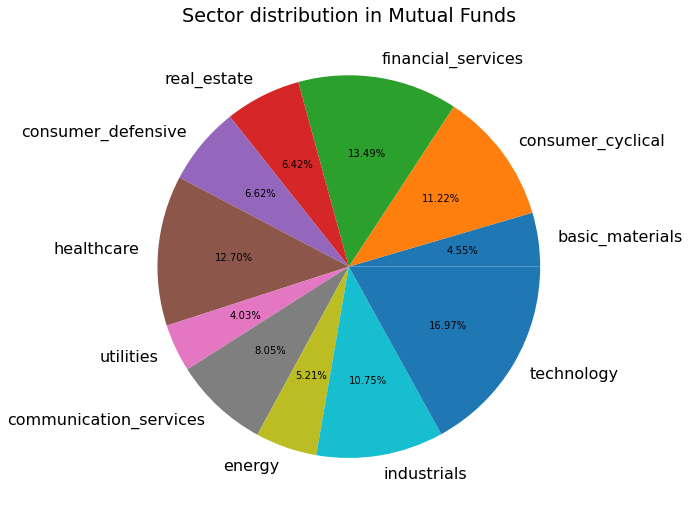

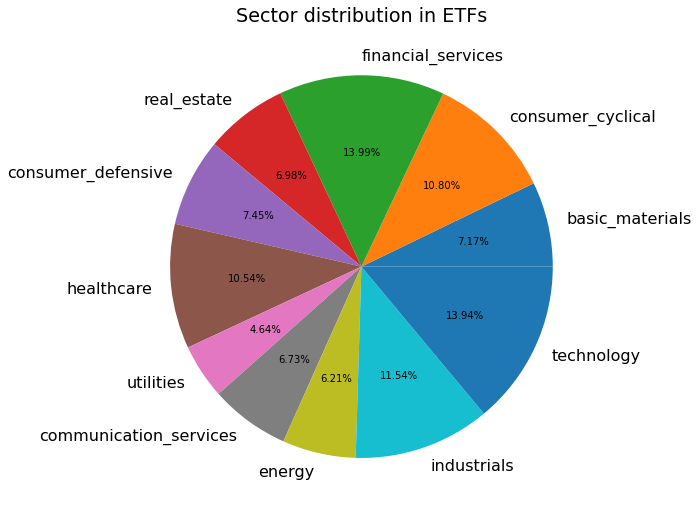

In [173]:
# Percentage invested in each sector
cols=[i for i in df_mf_sector.columns[1:12]]
plt.title('Sector distribution in Mutual Funds')
percent_comp_bar(df_mf_sector,cols,'sector_')
print('\n')
plt.title('Sector distribution in ETFs')
percent_comp_bar(df_etf_sector,cols,'sector_')


As we can see from the bar charts, the average sector holdings between both Mutual Funds and Exchange Traded Funds are very similar. The biggest margin of difference in sector holdings is about 3%. The biggest differences between sector holdings are that ETF's seem to have a 3% greater investment in companies in the basic materials sector and Mutual funds have roughly a 3% greater involvement in technology,healthcare, and communication services. We will perform a regression to see how correlated percent investment in each financial sector is with fund returns and if this slight difference in sector investment has an impact on fund returns.

Doing a single regression on sector investment and fund returns:

In [157]:
sectors=['sector_basic_materials','sector_consumer_cyclical','sector_financial_services','sector_real_estate',
        'sector_communication_services','sector_energy',
        'sector_industrials','sector_technology','sector_healthcare']

mfjoined=pd.merge(df_mf,df_mf_sector).dropna()
mfjoined=mfjoined.merge(df_mf_return_history).dropna()

mfs=get_correlations(mfjoined,sectors,'fund_return_ytd')


etfjoined=pd.merge(df_etf,df_etf_sector).dropna()
etfjoined=etfjoined.merge(df_etf_return_history).dropna()

etfs=get_correlations(etfjoined,sectors,'fund_return_ytd')





Cleaning up the column names: 

In [158]:

names=['Materials','Consumer Cyclical','Financial Services','Real Estate','Communication services','Energy','Industrials','Technology','Healthcare']
mfs.set_axis(names,axis=0,inplace=True)
etfs.set_axis(names,axis=0,inplace=True)


Visualizing the correlations with mutual funds:

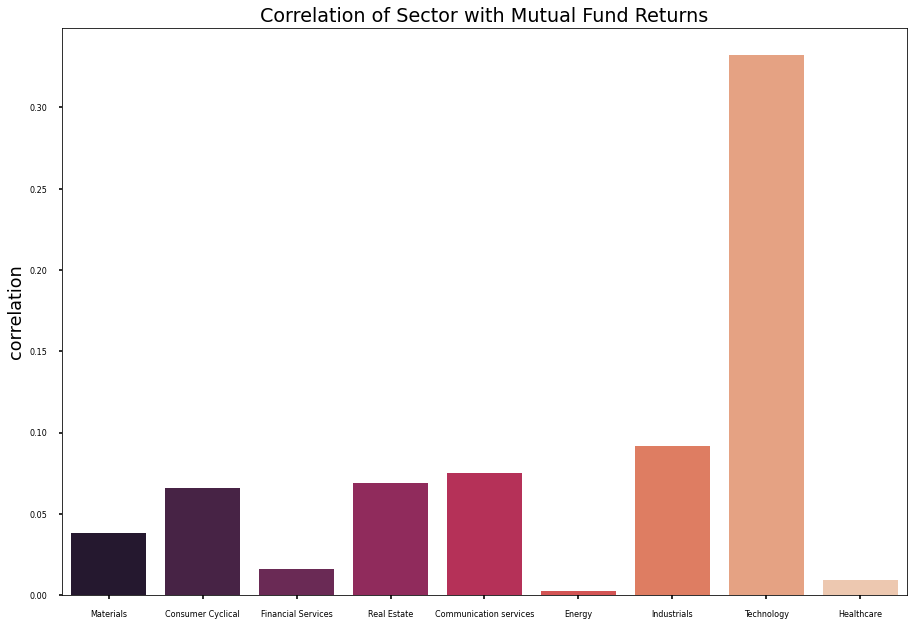

In [180]:
corr_visualize(mfs,'fund_return_ytd',.001,'Correlation of Sector with Mutual Fund Returns',8)

visualizing the correlation with ETFs:

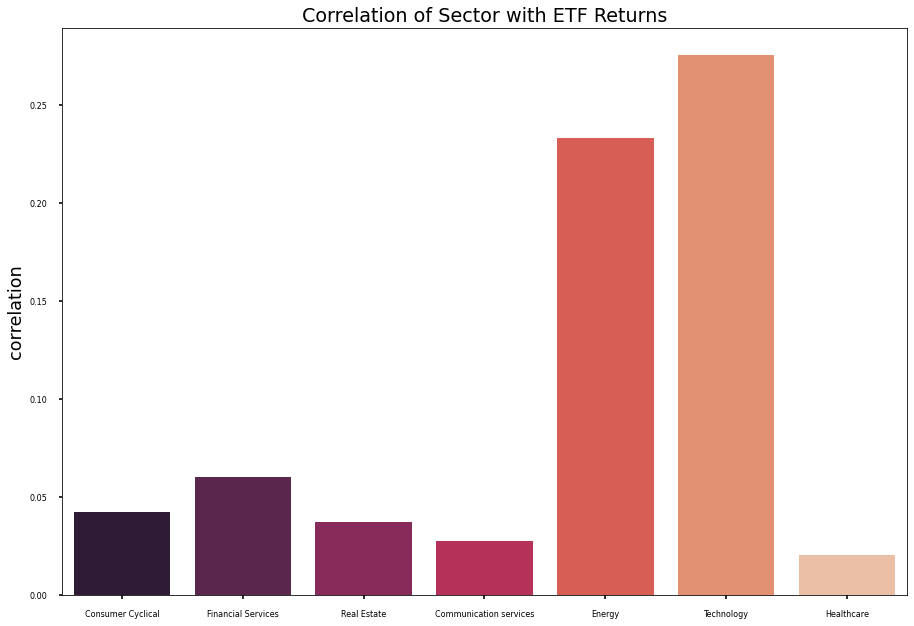

In [179]:
corr_visualize(etfs,'fund_return_ytd',.001,'Correlation of Sector with ETF Returns',8)


Visualizing the Correlations side by side:

(0.01, 0.4)

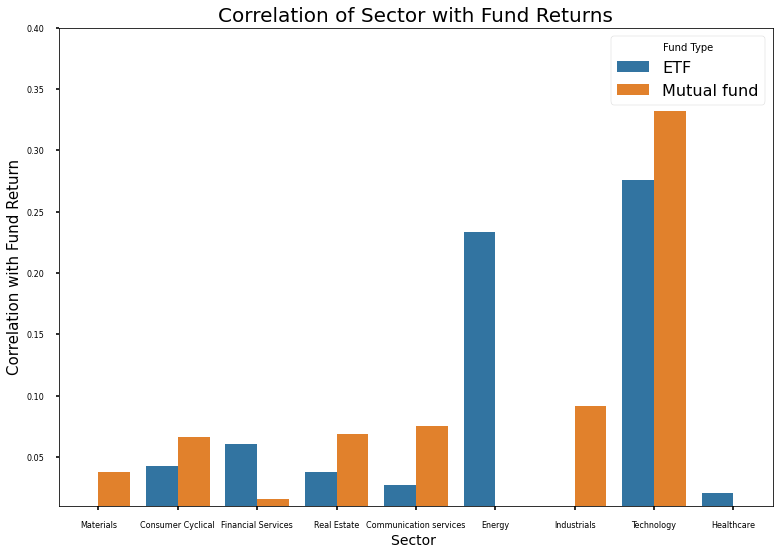

In [178]:
mfs['Fund Type']='Mutual fund'
etfs['Fund Type']='ETF'


sectors=['sector_basic_materials','sector_consumer_cyclical','sector_financial_services','sector_real_estate',
        'sector_communication_services','sector_energy',
        'sector_industrials','sector_technology','sector_healthcare']
bothsects=pd.concat([etfs,mfs])
g=sns.barplot(x=bothsects.index,y=bothsects['correlation'],data=bothsects,hue='Fund Type')
plt.tick_params(labelsize=8)

plt.title("Correlation of Sector with Fund Returns", fontsize = 20)
plt.xlabel("Sector ", fontsize = 14)
plt.ylabel("Correlation with Fund Return", fontsize = 15)
g.set_ylim(.01,.40)

As we can see from the visualization, sector investment generally has a positive and very weak correlation with fund returns. The highest correlation between sector investment and fund return is for technology investments. While this correlation is the strongest, it has a weak to moderate postitive correlation with fund returns with an r value of only .30 for ETFs and .35 for Mutual Funds. A shocking discovery is that investments in the energy sector is weakly to moderatetly correlated with fund returns for ETFs and not at all correlated to returns in Mutual Funds! In our breakdown of sector investment differences between Mutual Funds and ETFs we noted that Mutuals Funds invested more in technology,health care,and communication sectors and ETFs invested more in the basic materials sector. In our correlations we can see that investment in any of these sectors, besides the technology sector, had almost no correlation with fund returns. The differences in fund returns on a whole for Mutual Funds and ETFs then cannot be generally attributed to a difference in investment sectors.


Investors who have a positive outlook on energy stocks and want that sector to be well represented in the fund portfolio should likely look to invest in ETFs over Mutual Funds. Investment in the energy sector seemingly generates no returns for Mutual funds, and this could possibly be contributed to a variety of differences in the structure of mutual fund management. ETFs might have the advantage of allowing very diverse investment within the energy sector and are more likely to capture the rewards from the sector as a whole, while Mutual Funds may pick and choose certain energy companies they want to invest in - and they must have picked these companies poorly over the last decade. The overwhelming success of energy stocks such as Tesla have been downplayed and heavily shorted by fund managers, and this may explain why Mutual Funds don't seem to generate as much returns from the energy sector as ETFs do.

## Conclusion:

Apart from energy stocks it seems there is no concrete reason for a investor to choose investment in ETF over Mutual Funds or vice versa based solely on the investors desired sectors of investment. In the case that the investor is looking to invest in a fund with the hopes of capturing returns from the energy sector and energy stocks in particular, they should choose to invest in an ETF or other similar index fund over a Mutual Fund